In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 18.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4


In [2]:
!pip install torch

     |████████████████████████████████| 881.9 MB 9.4 kB/s             


In [3]:
!pip install tqdm

     |████████████████████████████████| 78 kB 1.1 MB/s             


In [4]:
!pip install torchvision

     |████████████████████████████████| 23.3 MB 21.5 MB/s            
     |████████████████████████████████| 881.9 MB 10 kB/s              
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2


In [10]:
!pip install captum

     |████████████████████████████████| 1.3 MB 18.6 MB/s            


✅ Figura salva como 'explicabilidade_grid.png'


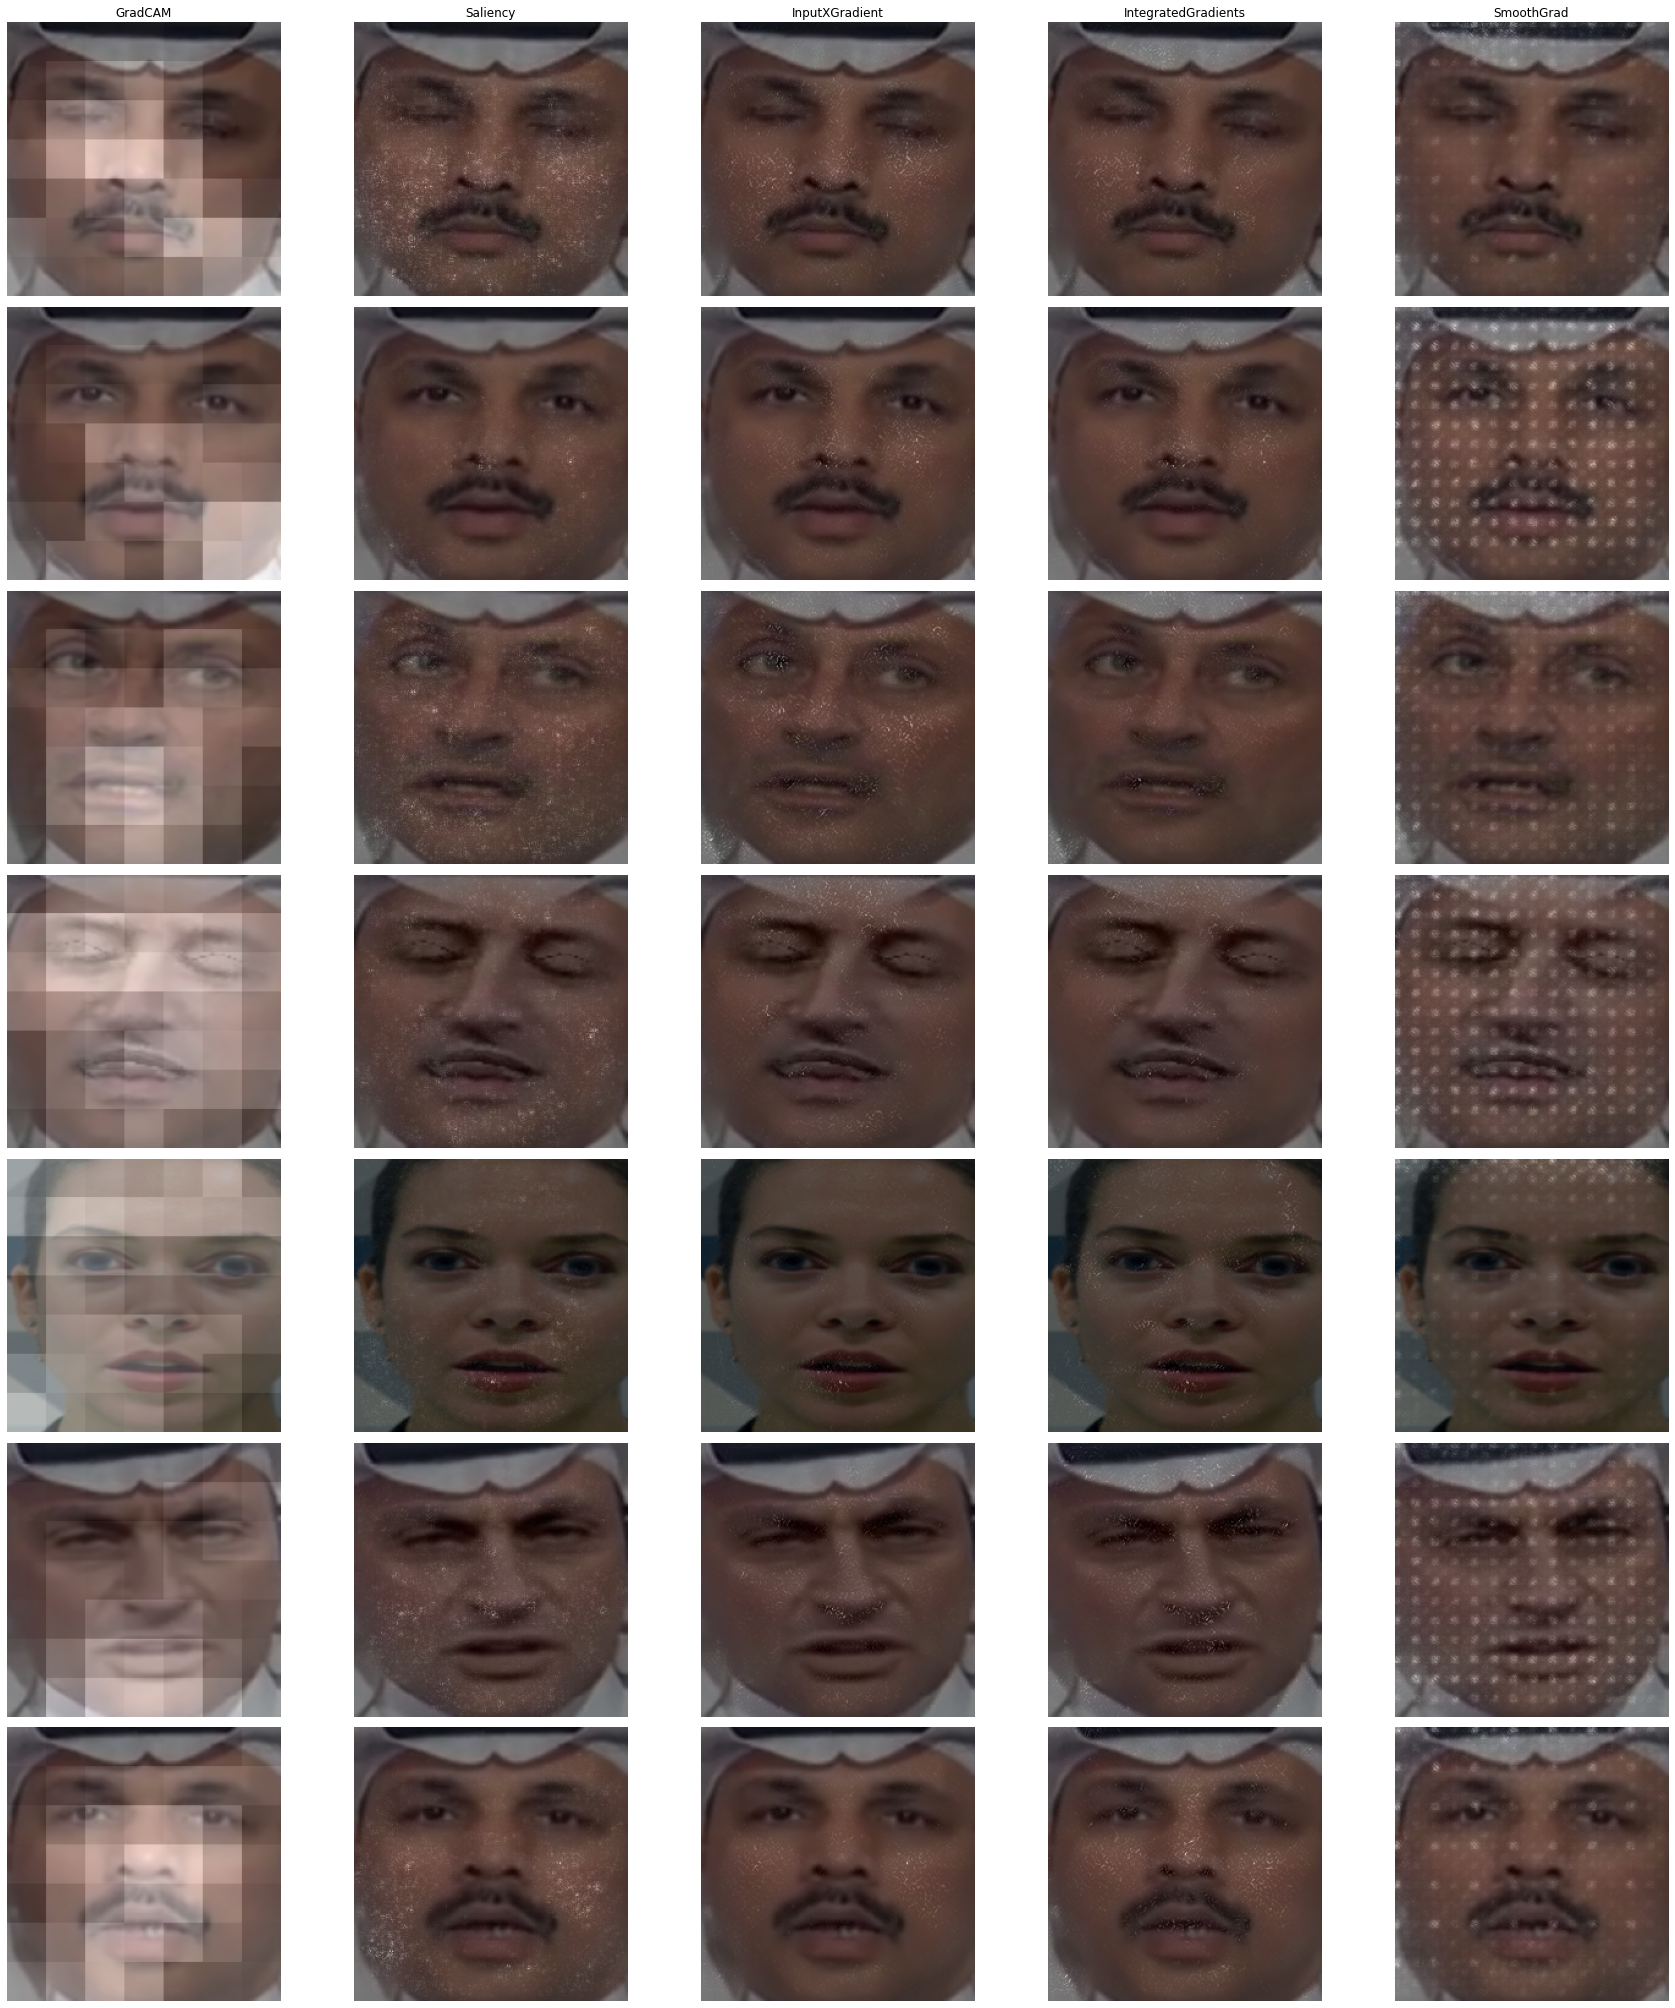

In [18]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from captum.attr import LayerGradCam, Saliency, IntegratedGradients, InputXGradient
from captum.attr import LayerAttribution
from captum.attr import NoiseTunnel

# Base do diretório
base_dir = "face_extraction/faceforensis_face_extract"

# Compatibilidade com torchvision < 0.13
model = models.resnet50(pretrained=False)  # Substitui weights=None
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("modelo_resnet50_frames.pth", map_location=torch.device('cpu')))
model.eval()

# -------- Transforms padrão para ResNet50 --------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    img_tensor.requires_grad_()  # Adicionado para evitar o warning do Captum
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255.0
    return img_tensor, img_np

def normalize_attr(attr):
    attr = np.maximum(attr, 0)
    if np.max(attr) > 0:
        attr = attr / np.max(attr)
    return np.stack([attr] * 3, axis=-1)

def generate_visualizations(model, img_tensor, img_np, label):
    target_layer = model.layer4[-1]

    gradcam = LayerGradCam(model, target_layer)
    gradcam_attr = gradcam.attribute(img_tensor, target=label)
    gradcam_attr = LayerAttribution.interpolate(gradcam_attr, (224, 224)).squeeze().detach().numpy()

    saliency = Saliency(model)
    saliency_attr = saliency.attribute(img_tensor, target=label).squeeze().abs().detach().numpy().mean(axis=0)

    inputxgrad = InputXGradient(model)
    inputxgrad_attr = inputxgrad.attribute(img_tensor, target=label).squeeze().detach().numpy().mean(axis=0)

    integrated = IntegratedGradients(model)
    integrated_attr = integrated.attribute(img_tensor, target=label, n_steps=50).squeeze().detach().numpy().mean(axis=0)

    smoothgrad = NoiseTunnel(saliency)
    smoothgrad_attr = smoothgrad.attribute(img_tensor, nt_type="smoothgrad", target=label).squeeze().detach().numpy().mean(axis=0)

    vis = []
    for attr in [gradcam_attr, saliency_attr, inputxgrad_attr, integrated_attr, smoothgrad_attr]:
        blended = np.clip(img_np * 0.5 + normalize_attr(attr) * 0.5, 0, 1)
        vis.append(blended)
    return vis

# Classes e imagens
image_groups = {
    "ORIGINAL": [
        f"{base_dir}/train/original/original_000_frame5.png",
        f"{base_dir}/train/original/original_004_frame2.png",
        f"{base_dir}/train/original/original_006_frame1.png",
        f"{base_dir}/train/original/original_011_frame4.png",
        f"{base_dir}/train/original/original_018_frame3.png",
    ],
    "FACE2FACE": [
        f"{base_dir}/train/face2face/Face2Face_000_003_frame5.png",
        f"{base_dir}/train/face2face/Face2Face_002_006_frame3.png",
        f"{base_dir}/train/face2face/Face2Face_006_002_frame5.png",
        f"{base_dir}/train/face2face/Face2Face_010_005_frame3.png",
        f"{base_dir}/train/face2face/Face2Face_017_803_frame3.png",
    ],
    "FACESHIFTER": [
        f"{base_dir}/train/FaceShifter/FaceShifter_000_003_frame5.png",
        f"{base_dir}/train/FaceShifter/FaceShifter_002_006_frame5.png",
        f"{base_dir}/train/FaceShifter/FaceShifter_006_002_frame5.png",
        f"{base_dir}/train/FaceShifter/FaceShifter_010_005_frame3.png",
        f"{base_dir}/train/FaceShifter/FaceShifter_017_803_frame3.png",
    ],
    "FACESWAP": [
        f"{base_dir}/train/FaceSwap/FaceSwap_000_003_frame5.png",
        f"{base_dir}/train/FaceSwap/FaceSwap_002_006_frame5.png",
        f"{base_dir}/train/FaceSwap/FaceSwap_006_002_frame5.png",
        f"{base_dir}/train/FaceSwap/FaceSwap_010_005_frame3.png",
        f"{base_dir}/train/FaceSwap/FaceSwap_017_803_frame3.png",
    ],
    "DEEPFAKEDETECTION": [
        f"{base_dir}/train/DeepFakeDetection/DeepFakeDetection_01_02__talking_against_wall__YVGY8LOK_frame4.png",
        f"{base_dir}/train/DeepFakeDetection/DeepFakeDetection_01_04__talking_angry_couch__0XUW13RW_frame3.png",
        f"{base_dir}/train/DeepFakeDetection/DeepFakeDetection_01_15__kitchen_still__02HILKYO_frame5.png",
        f"{base_dir}/train/DeepFakeDetection/DeepFakeDetection_01_21__walk_down_hall_angry__03X7CELV_frame1.png",
        f"{base_dir}/train/DeepFakeDetection/DeepFakeDetection_01_27__meeting_serious__ZYCZ30C0_frame3.png",
    ],
    "DEEPFAKES": [
        f"{base_dir}/train/deepfakes/Deepfakes_000_003_frame5.png",
        f"{base_dir}/train/deepfakes/Deepfakes_002_006_frame5.png",
        f"{base_dir}/train/deepfakes/Deepfakes_006_002_frame5.png",
        f"{base_dir}/train/deepfakes/Deepfakes_010_005_frame3.png",
        f"{base_dir}/train/deepfakes/Deepfakes_017_803_frame3.png",
    ],
    "NEURALTEXTURES": [
        f"{base_dir}/train/NeuraTextures/NeuralTextures_000_003_frame5.png",
        f"{base_dir}/train/NeuraTextures/NeuralTextures_002_006_frame5.png",
        f"{base_dir}/train/NeuraTextures/NeuralTextures_006_002_frame5.png",
        f"{base_dir}/train/NeuraTextures/NeuralTextures_010_005_frame3.png",
        f"{base_dir}/train/NeuraTextures/NeuralTextures_017_803_frame3.png",
    ],
}

def show_explanations_grid():
    techniques = ["GradCAM", "Saliency", "InputXGradient", "IntegratedGradients", "SmoothGrad"]
    fig, axs = plt.subplots(len(image_groups), len(techniques), figsize=(5*len(techniques), 4*len(image_groups)))
    for row_idx, (label, image_list) in enumerate(image_groups.items()):
        img_tensor, img_np = load_image_tensor(image_list[0])  # primeira imagem da classe
        pred = torch.argmax(torch.nn.functional.softmax(model(img_tensor), dim=1)).item()
        vis_list = generate_visualizations(model, img_tensor, img_np, pred)
        for col_idx, vis in enumerate(vis_list):
            axs[row_idx, col_idx].imshow(vis)
            axs[row_idx, col_idx].axis('off')
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(techniques[col_idx], fontsize=12)
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(label, fontsize=12)
    plt.tight_layout()
    plt.savefig("explicabilidade_grid.png")  # Salva o resultado como imagem
    print("✅ Figura salva como 'explicabilidade_grid.png'")
    plt.show(block=True)

# Executar
if __name__ == "__main__":
    show_explanations_grid()
